In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


# **AutoEncoder on Both Trainin and Test, since it is Unsupervised**

In [18]:
# ==========================================================
#  FULL-STACK DENOISING AUTO-ENCODER  (GPU Edition)
#  • IEEE-CIS train + test, unsupervised fit
#  • Outputs submission.csv  (TransactionID, anomaly score)
# ==========================================================

# ---------- 0. Imports & GPU config -----------------------
import gc, os, numpy as np, pandas as pd, tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, average_precision_score


In [19]:
# ---------------- CONFIG ----------------------------------
DATA_DIR   = Path('/kaggle/input/ieee-fraud-detection')
VAL_FRAC   = 0.10         # 10 % validation slice from train
RAND       = 42
EPOCHS     = 12
BATCH      = 2048
NOISE_STD  = 0.05
ALERT_CAP  = 2_000        # validation alert quota
# ----------------------------------------------------------


In [20]:
# 1 ───────── Load & merge  (≈ 2 GB RAM) ───────────────────
print('Loading CSVs …')
train = (pd.read_csv(DATA_DIR/'train_transaction.csv')
         .merge(pd.read_csv(DATA_DIR/'train_identity.csv'),
                 on='TransactionID', how='left'))
test  = (pd.read_csv(DATA_DIR/'test_transaction.csv')
         .merge(pd.read_csv(DATA_DIR/'test_identity.csv'),
                 on='TransactionID', how='left'))

y_full  = train['isFraud'].astype('int8').values
train_X = train.drop(columns='isFraud')
test_X  = test.copy()
full    = pd.concat([train_X, test_X], ignore_index=True)

# FREE RAM #1
del train, test, train_X, test_X
gc.collect()

Loading CSVs …


1018

In [21]:
# 2 ───────── Frequency encoder (fit on TRAIN ONLY) ────────
class FreqEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, drop=True): self.drop = drop
    def fit(self, X, y=None):
        obj = X.select_dtypes('object')
        self.maps_ = {c: obj[c].value_counts(normalize=True) for c in obj}
        self.cols_ = list(self.maps_)
        return self
    def transform(self, X):
        X = X.copy()
        for c, m in self.maps_.items():
            X[c + '_fq'] = X[c].map(m).astype('float32').fillna(0.0)
        return X.drop(columns=self.cols_) if self.drop else X

joblib.dump(FreqEncoder, 'freq_encoder.pkl')



['freq_encoder.pkl']

In [22]:

fe = FreqEncoder().fit(full.iloc[:len(y_full)])   # fit on labelled rows only
full = fe.transform(full)



# FREE RAM #2
gc.collect()


27

In [23]:
# 3 ───────── Impute (+ flags)  ➜  scale  ➜  float32 ───────
imp = SimpleImputer(strategy='constant', fill_value=-999, add_indicator=True)
full_imp = imp.fit_transform(full)         # ndarray (float64)

joblib.dump(imp, 'imputer.pkl')

# FREE RAM #3
del full
gc.collect()

scaler = StandardScaler()
full_scaled = scaler.fit_transform(full_imp).astype('float32')

joblib.dump(scaler, 'scaler.pkl')

# FREE RAM #4
del full_imp
gc.collect()


0

In [24]:
# 4 ───────── Split back to train / test & hold-out val ────
n_train   = len(y_full)
X_train   = full_scaled[:n_train]
X_test    = full_scaled[n_train:]

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_full, test_size=VAL_FRAC,
    stratify=y_full, random_state=RAND)

In [25]:
# 5 ───────── Build CPU denoising auto-encoder ─────────────
n_in = X_tr.shape[1]
inp  = tf.keras.Input(shape=(n_in,))
x    = tf.keras.layers.GaussianNoise(NOISE_STD)(inp)
for units in (512, 256, 128, 64):
    x = tf.keras.layers.Dense(units, activation='relu')(x)
latent = tf.keras.layers.Dense(32, activation='relu')(x)
for units in (64, 128, 256, 512):
    x = tf.keras.layers.Dense(units, activation='relu')(latent)
out   = tf.keras.layers.Dense(n_in)(x)

dae = tf.keras.Model(inp, out)
dae.compile(optimizer='adam', loss='mse')

print('\nTraining DAE on CPU …')
dae.fit(
    X_tr, X_tr,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_val, X_val),
    verbose=2
)



Training DAE on CPU …
Epoch 1/12
260/260 - 36s - 138ms/step - loss: 0.1890 - val_loss: 0.1994
Epoch 2/12
260/260 - 32s - 122ms/step - loss: 0.0895 - val_loss: 0.1867
Epoch 3/12
260/260 - 32s - 123ms/step - loss: 0.1605 - val_loss: 0.2089
Epoch 4/12
260/260 - 32s - 123ms/step - loss: 0.1523 - val_loss: 0.1224
Epoch 5/12
260/260 - 32s - 122ms/step - loss: 0.1388 - val_loss: 0.2189
Epoch 6/12
260/260 - 36s - 139ms/step - loss: 0.1060 - val_loss: 0.1592
Epoch 7/12
260/260 - 32s - 123ms/step - loss: 0.1305 - val_loss: 0.0594
Epoch 8/12
260/260 - 32s - 122ms/step - loss: 0.0626 - val_loss: 0.0617
Epoch 9/12
260/260 - 32s - 123ms/step - loss: 0.0326 - val_loss: 0.0276
Epoch 10/12
260/260 - 32s - 122ms/step - loss: 0.0337 - val_loss: 0.0241
Epoch 11/12
260/260 - 32s - 123ms/step - loss: 0.0299 - val_loss: 0.0347
Epoch 12/12
260/260 - 32s - 122ms/step - loss: 0.0232 - val_loss: 0.1222


In [26]:
# 6 ───────── Validation score & threshold by quota ────────
val_rec = np.mean((X_val - dae.predict(X_val, verbose=0))**2, axis=1)
thr = np.sort(val_rec)[::-1][min(ALERT_CAP, len(val_rec))-1]

tp   = ((val_rec >= thr) & (y_val==1)).sum()
prec = tp / max(1, (val_rec >= thr).sum())
rec  = tp / (y_val==1).sum()
f1   = 2*prec*rec/(prec+rec+1e-9)
pr   = average_precision_score(y_val, val_rec)

print(f'\nValidation ({ALERT_CAP} alerts)  P={prec:.3f}  R={rec:.3f}  F1={f1:.3f}  PR-AUC={pr:.3f}')

# FREE RAM #6  – validation arrays no longer needed
del X_tr, X_val
gc.collect()



Validation (2000 alerts)  P=0.095  R=0.092  F1=0.093  PR-AUC=0.075


1561

In [27]:
# 7 ───────── Optional fine-tune on full stack ──────────────
dae.fit(full_scaled, full_scaled, epochs=2, batch_size=BATCH, verbose=2)

Epoch 1/2
536/536 - 63s - 117ms/step - loss: 0.1146
Epoch 2/2
536/536 - 62s - 117ms/step - loss: 0.0825


In [28]:
# 8 ───────── Score TEST & write submission ─────────────────
test_rec = np.mean((X_test - dae.predict(X_test, verbose=0))**2, axis=1)

sub = pd.DataFrame({
    'TransactionID': pd.read_csv(DATA_DIR/'test_transaction.csv')['TransactionID'],
    'isFraud': test_rec          # raw anomaly score
})
sub.to_csv('submission.csv', index=False)
print('\nsubmission.csv saved ✔︎')


dae.save('dae_full.keras')   
encoder = tf.keras.Model(dae.input, dae.layers[-5].output)
encoder.save('dae_encoder.keras')        # just the 32-d encoder


submission.csv saved ✔︎


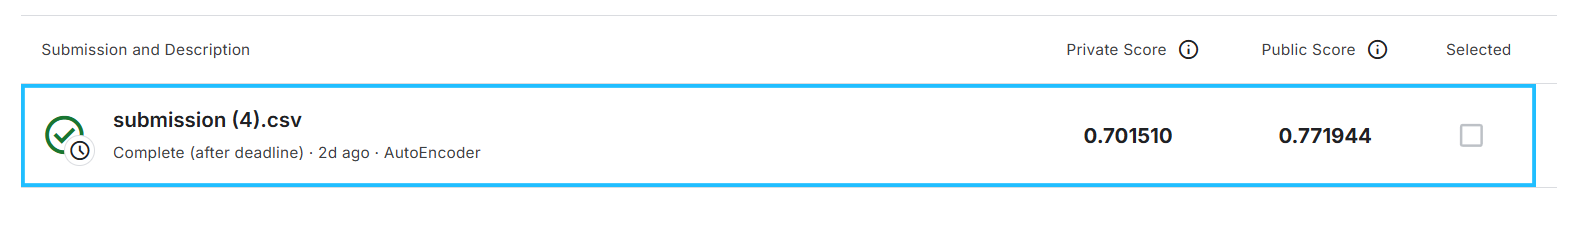
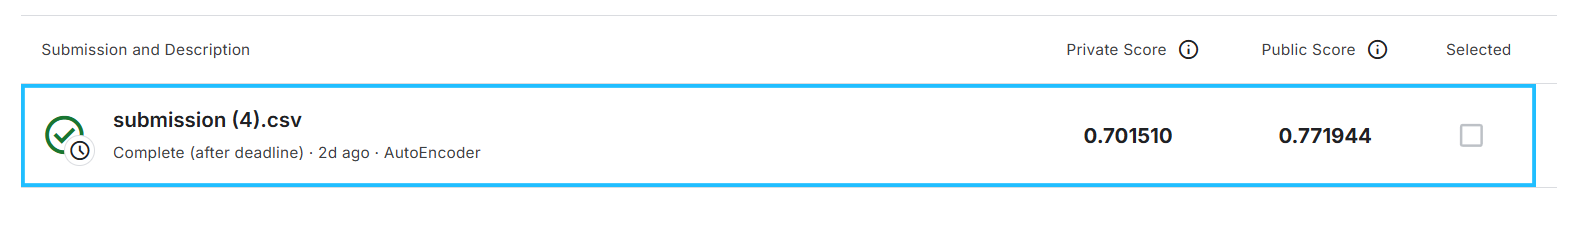
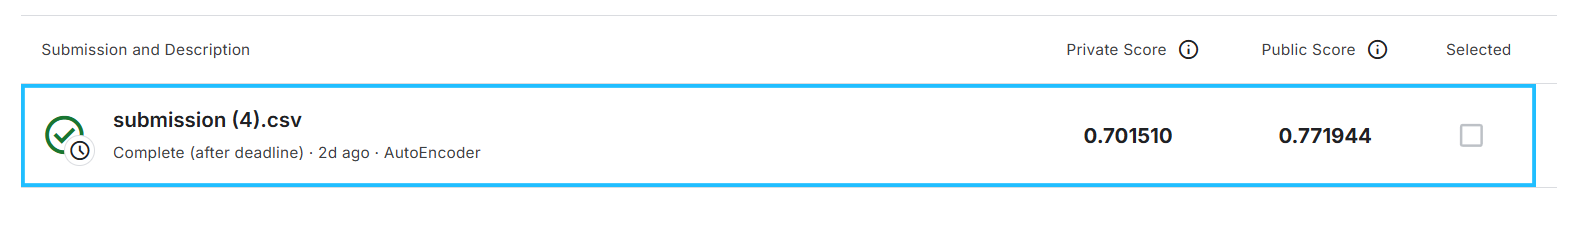
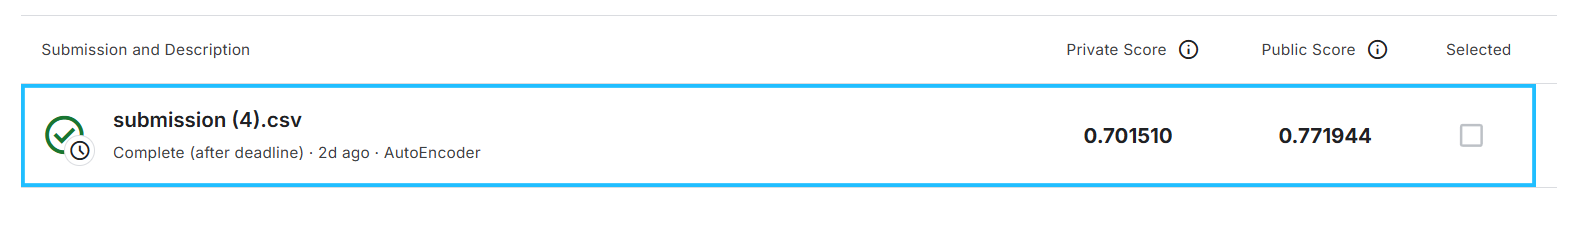